# Build TensorFlow Lite model for handwritten digit classifier app

## Import Dependencies

In [0]:
# We start by importing TensorFlow and other supporting libraries 
# that are used for data processing and visualization.

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import random

## Getting the MNIST dataset

The MNIST database contains 60,000 training images and 10,000 testing images of handwritten digits. We will use the dataset to train our digit classification model.

Each image in the MNIST dataset is a 28x28 grayscale image containing a digit from 0 to 9, and a label identifying which digit is in the image.

![MNIST sample](https://github.com/khanhlvg/DigitClassifier/raw/master/images/mnist.png)

### Loading the data

In [0]:
# We use the Keras API to load and split the MNIST dataset to train and test dataset

mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


### Preprocessing the data

In [0]:
# Normalize the input image so that each pixel value is between 0 to 1.

train_images = train_images / 255.0
test_images = test_images / 255.0

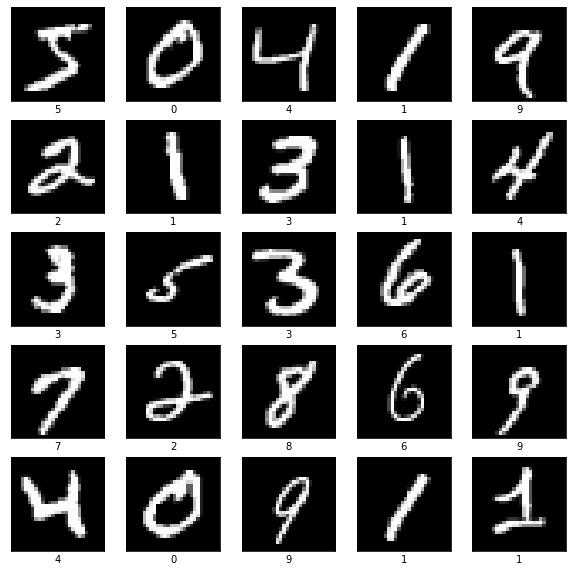

In [0]:
# Show the first 25 images in the training dataset.

plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.gray)
  plt.xlabel(train_labels[i])
plt.show()

## Create the model

Our model takes a 28px x 28px grayscale image as an input, and outputs a float array of length 10 representing the probability of the image being a digit from 0 to 9.

In [0]:
# Define the model

model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Dropout(0.25),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])

# Compile the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model

model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1408 - accuracy: 0.9580
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0539 - accuracy: 0.9837
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0397 - accuracy: 0.9878
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0310 - accuracy: 0.9900
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0240 - accuracy: 0.9923


In [0]:
# Check the structure of our model

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                9

## Test the model

In [0]:
# Evaluate the model using all images in the test dataset.

test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.0340 - accuracy: 0.9897
Test accuracy: 0.9897000193595886


## Visualising the results

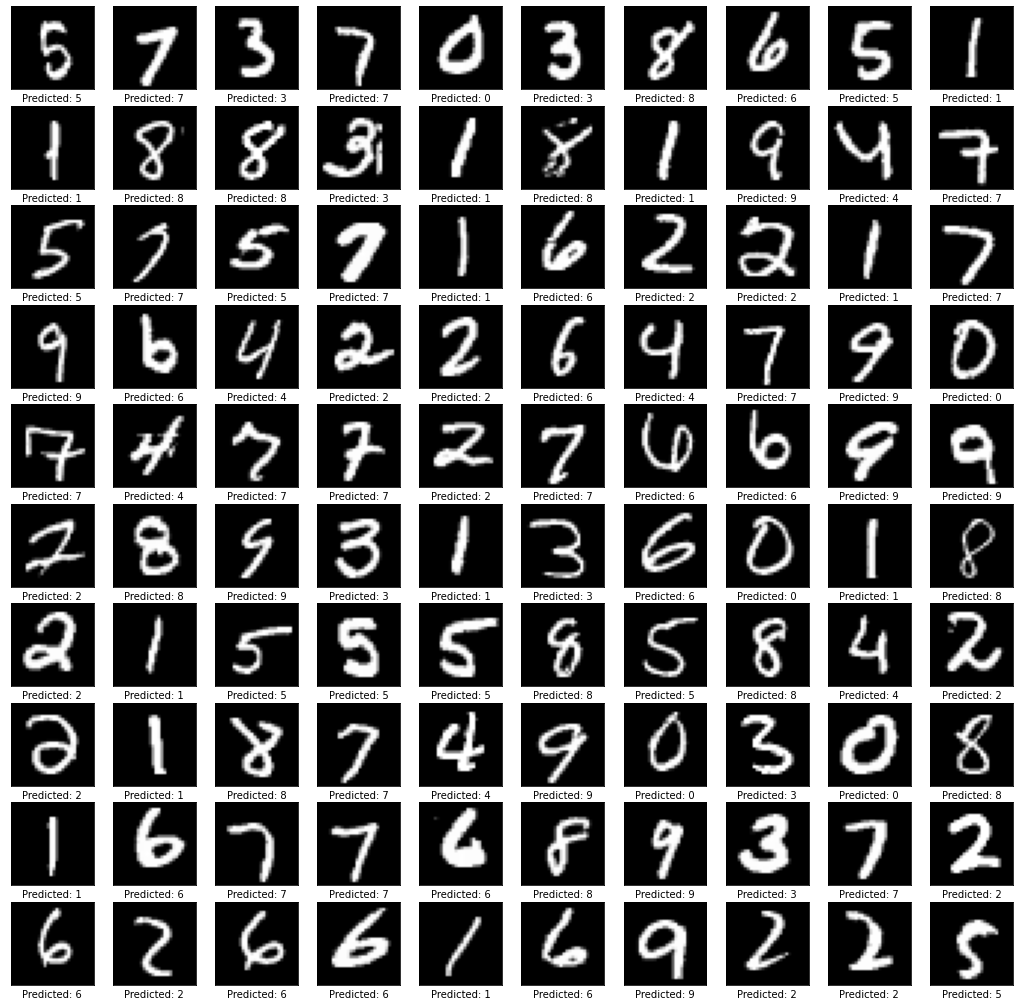

In [0]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.

def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Predict the labels of digit images in our test dataset.

predictions = model.predict(test_images)

# As the model output 10 float representing the probability of the input image
# being a digit from 0 to 9, we need to find the largest probability value
# to find out which digit the model predicts to be most likely in the image.

prediction_digits = np.argmax(predictions, axis=1)

# Then plot 100 random test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.

plt.figure(figsize=(18, 18))
for i in range(100):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image_index = random.randint(0, len(prediction_digits))
  plt.imshow(test_images[image_index], cmap=plt.cm.gray)
  ax.xaxis.label.set_color(get_label_color(prediction_digits[image_index],\
                                           test_labels[image_index]))
  plt.xlabel('Predicted: %d' % prediction_digits[image_index])
plt.show()

## Convert the Keras model to TensorFlow Lite

In [0]:
# Convert Keras model to TF Lite format.

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

# Show model size in KBs.

float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

Float model size = 435KBs.


Now we reconvert the model using quantization techniques

In [0]:
# Here we will use 8-bit number to approximate our 32-bit weights, 
# which in turn shrinks the model size by a factor of 4.

# Re-convert the model to TF Lite using quantization.

converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.

quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

Quantized model size = 111KBs,
which is about 25% of the float model size.


## Evaluate the TensorFlow Lite model

In [0]:
# A helper function to evaluate the TF Lite model using test dataset.

def evaluate_tflite_model(tflite_model):
  # Initialize TFLite interpreter using the model.

  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors() # memory allocation for input and output tensors
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

  # Run predictions on every image in the "test" dataset.

  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.

    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_tensor_index, test_image)

    # Run inference.

    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.

    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.

  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

# Evaluate the TF Lite float model.

float_accuracy = evaluate_tflite_model(tflite_float_model)
print('Float model accuracy = %.4f' % float_accuracy)

# Evalualte the TF Lite quantized model.

quantized_accuracy = evaluate_tflite_model(tflite_quantized_model)
print('Quantized model accuracy = %.4f' % quantized_accuracy)
print('Accuracy drop = %.4f' % (float_accuracy - quantized_accuracy))


Float model accuracy = 0.9897
Quantized model accuracy = 0.9897
Accuracy drop = 0.0000


## Download the TensorFlow Lite model

In [0]:
# Save the quantized model to file to the Downloads directory

f = open('mnist.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

# Download the digit classification model
from google.colab import files
files.download('mnist.tflite')

print('`mnist.tflite` has been downloaded')

`mnist.tflite` has been downloaded
